In [28]:
import import_ipynb
import data_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

- remove seasonablity
- drop nans (if pre-processing from seasonality)
- others?
- try to understand autocorrelation in initial features
- 

- get residuals for each timestep
- cluster the residuals
- adaptive thresholding (exponential moving average could be good)
- use windowing to be more robust to what average values should be. 
- feature engineering -> add month, add important interaction terms, 

- rule based detection (set threshold based on training data)
- require multiple anomalies in a row to happen in order to flag is an anomaly. 

In [2]:
# training data
u4_train_equil_turbine = data_preprocessing.u4_train_equil_turbine
u4_train_equil_pump = data_preprocessing.u4_train_equil_pump
u5_train_equil_turbine = data_preprocessing.u5_train_equil_turbine
u5_train_equil_pump = data_preprocessing.u5_train_equil_pump
u6_train_equil_turbine = data_preprocessing.u6_train_equil_turbine
u6_train_equil_pump = data_preprocessing.u6_train_equil_pump

# synethetic test sets
u5_s01_equil_turbine = data_preprocessing.u5_s01_equil_turbine
u5_s01_equil_pump = data_preprocessing.u5_s01_equil_pump
u5_s02_equil_turbine = data_preprocessing.u5_s02_equil_turbine
u5_s02_equil_pump = data_preprocessing.u5_s02_equil_pump
u6_s01_equil_turbine = data_preprocessing.u6_s01_equil_turbine
u6_s01_equil_pump = data_preprocessing.u6_s01_equil_pump
u6_s02_equil_turbine = data_preprocessing.u6_s02_equil_turbine
u6_s02_equil_pump = data_preprocessing.u6_s02_equil_pump

# real test sets
u4_test_equil_turbine = data_preprocessing.u4_test_equil_turbine
u4_test_equil_pump = data_preprocessing.u4_test_equil_pump
u5_test_equil_turbine = data_preprocessing.u5_test_equil_turbine
u5_test_equil_pump = data_preprocessing.u5_test_equil_pump
u6_test_equil_turbine = data_preprocessing.u6_test_equil_turbine
u6_test_equil_pump = data_preprocessing.u6_test_equil_pump

In [5]:
features = [
    'tot_activepower', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening',
    'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow',
    'pump_pressure_diff', 'pump_rotspeed', 'turbine_pressure', 'turbine_rotspeed',
    'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'timer_turbine_on_off'
]

In [29]:
# Check if 'timer_turbine_on_off' is present; if not, exclude it from the feature list
features = [feature for feature in features if feature in u5_train_equil_pump.columns]

target = 'stat_magn_01_tmp'

# Split the data into training and testing sets
X = u5_train_equil_pump[features]
y = u5_train_equil_pump[target]

In [30]:
# Standardize the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"Reduced number of features from {X.shape[1]} to {X_pca.shape[1]}")

Reduced number of features from 15 to 12


In [31]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
model.fit(X, y)


# Predict on the test set
y_pred = model.predict(X)

residuals = y - y_pred

# Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r_squared = r2_score(y_test, y_pred)


# print(f'Mean Squared Error: {mse}')
# print(f'Root Mean Squared Error: {rmse}')
# print(f"R squared : {r_squared}")

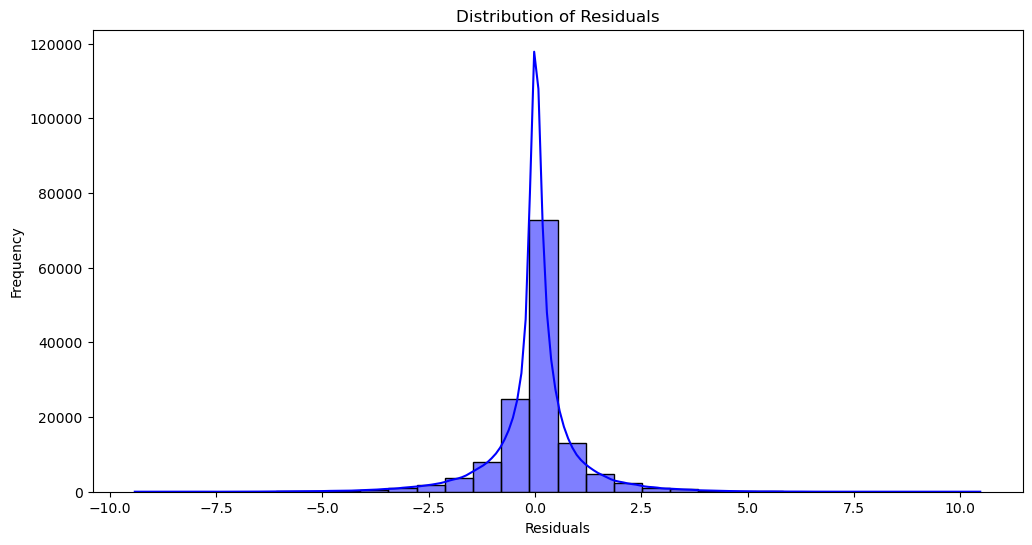

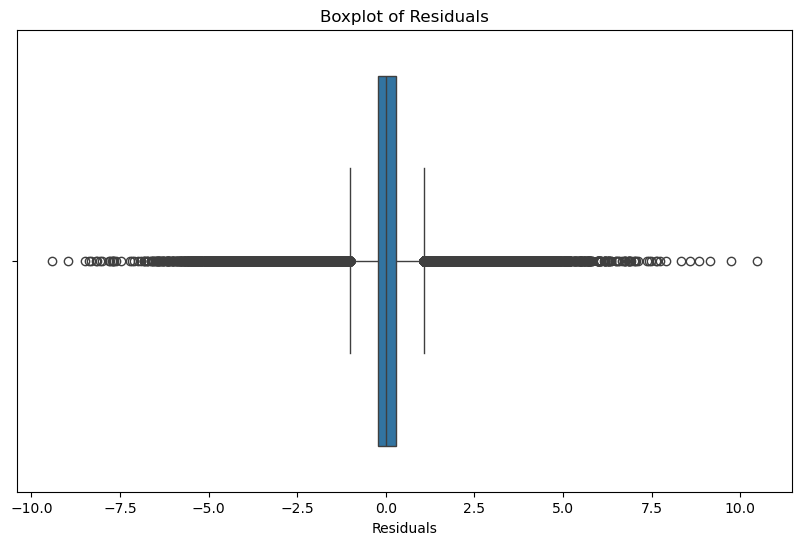

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Optionally, also plot a boxplot to see outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=residuals)
plt.title('Boxplot of Residuals')
plt.xlabel('Residuals')
plt.show()

In [33]:
# Basic statistical measures
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
max_residual = np.max(residuals)
min_residual = np.min(residuals)

print(f"Mean of Residuals: {mean_residual}")
print(f"Standard Deviation of Residuals: {std_residual}")
print(f"Max Residual: {max_residual}")
print(f"Min Residual: {min_residual}")


# Example threshold at 3 standard deviations from the mean
threshold = mean_residual + 4 * std_residual
print(f"Anomaly Threshold: {threshold}")

Mean of Residuals: 0.004153303162994428
Standard Deviation of Residuals: 0.9819664398394126
Max Residual: 10.470442674395109
Min Residual: -9.40706241065164
Anomaly Threshold: 3.9320190625206446


In [34]:
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
# plt.show()

# # Plot the actual and predicted values over the test set
# plt.figure(figsize=(14, 7))
# plt.scatter(y_test.index, y_test)
# plt.scatter(y_test.index, y_pred)
# # plt.plot(y_test.index, y_test, label='Actual Values', color='blue', marker='o')
# # plt.plot(y_test.index, y_pred, label='Predicted Values', color='red', linestyle='--', marker='x')
# plt.title('Comparison of Actual and Predicted Values')
# plt.xlabel('Index')
# plt.ylabel('Stator Coil Temperature')
# plt.legend()
# plt.show()

In [35]:
# Extracting the features and target from the synthetic test set
X_synthetic = u5_s01_equil_pump[features]
y_synthetic = u5_s01_equil_pump['stat_magn_01_tmp']

# Predict using the trained model
y_pred_synthetic = model.predict(X_synthetic)

In [36]:
# Evaluate the model performance on synthetic data
mse_synthetic = mean_squared_error(y_synthetic, y_pred_synthetic)
rmse_synthetic = np.sqrt(mse_synthetic)
r_squared_synthetic = r2_score(y_synthetic, y_pred_synthetic)

print(f'Mean Squared Error on Synthetic Data: {mse_synthetic}')
print(f'Root Mean Squared Error on Synthetic Data: {rmse_synthetic}')
print(f"R squared : {r_squared_synthetic}")

Mean Squared Error on Synthetic Data: 38.025780565415666
Root Mean Squared Error on Synthetic Data: 6.166504728402928
R squared : 0.5249592900360835


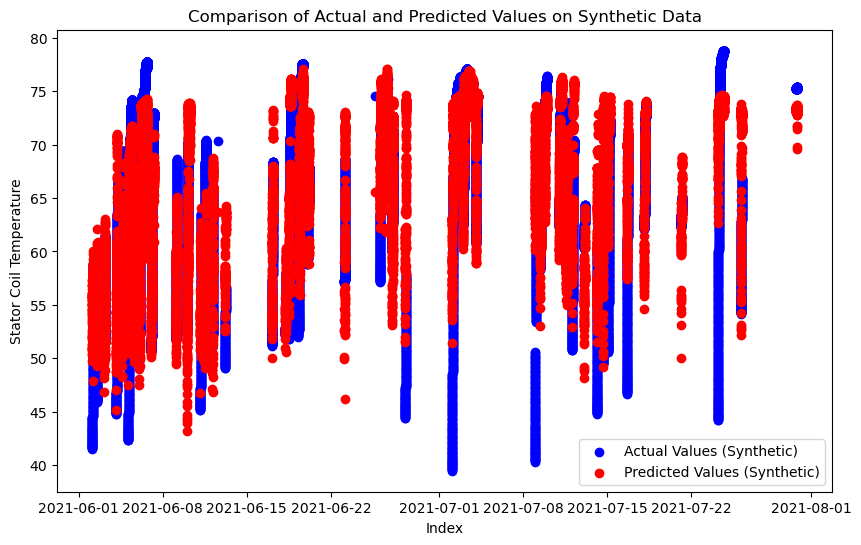

In [37]:
# Visualizing the results with a scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_synthetic.index, y_synthetic, label='Actual Values (Synthetic)', color='blue')
plt.scatter(y_synthetic.index, y_pred_synthetic, label='Predicted Values (Synthetic)', color='red')
plt.title('Comparison of Actual and Predicted Values on Synthetic Data')
plt.xlabel('Index')
plt.ylabel('Stator Coil Temperature')
plt.legend()
plt.show()

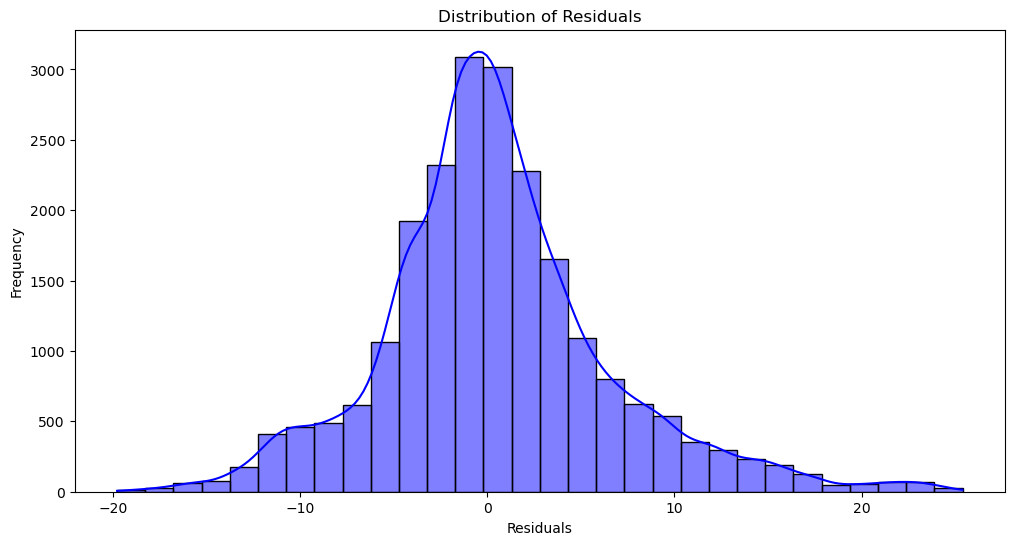

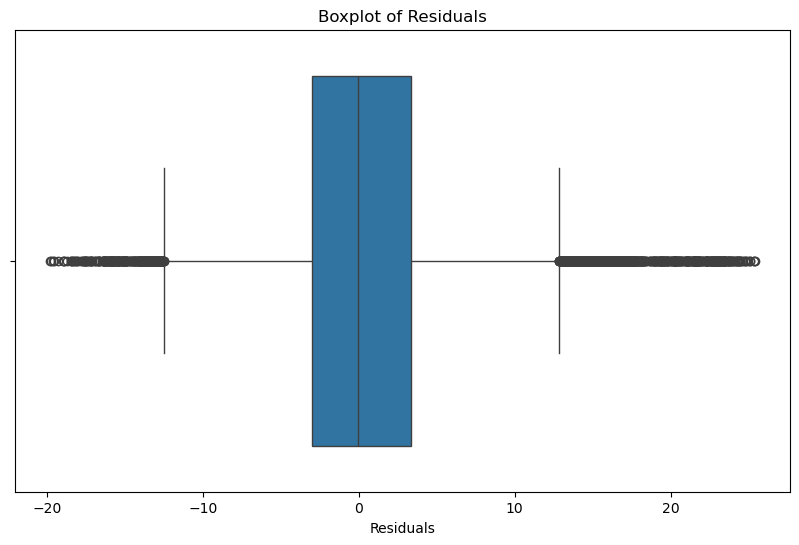

In [38]:
residuals_synthetic = y_pred_synthetic - y_synthetic

plt.figure(figsize=(12, 6))
sns.histplot(residuals_synthetic, kde=True, color='blue', bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Optionally, also plot a boxplot to see outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=residuals_synthetic)
plt.title('Boxplot of Residuals')
plt.xlabel('Residuals')
plt.show()

In [39]:
# Step 3: Classify based on threshold
residuals_abs = np.abs(residuals_synthetic)

predicted_anomalies = (residuals_abs > threshold).astype(int)

# Step 4: Evaluate the model
true_anomalies = u5_s01_equil_pump['anomaly']

accuracy = accuracy_score(true_anomalies, predicted_anomalies)
f1 = f1_score(true_anomalies, predicted_anomalies)
conf_matrix = confusion_matrix(true_anomalies, predicted_anomalies)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.40488310284247037
F1 Score: 0.5502944480375804
Confusion Matrix:
[[  905  1215]
 [11996  8083]]


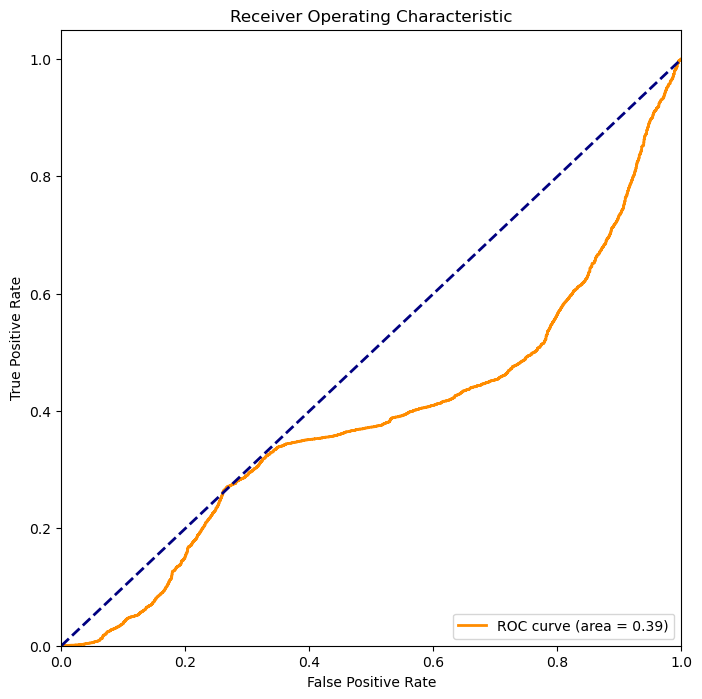

In [40]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(true_anomalies, residuals_abs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()